In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import RidgeCV
from pmdarima import auto_arima
import sys
import re
import seaborn as sns
from collections import Counter

from tqdm.auto import tqdm

# Lets have a look at data

## Data prepare

In [2]:
data = pd.read_csv('dataset.csv').drop(columns='Unnamed: 0')
data['local_date'] = pd.to_datetime(data.local_date)
data.head()

,item_id,receipt_id,device_id,local_date,barcode,price,quantity,region
0,11660931229,7364786357,352402250963288,2021-02-02 00:00:01,46200310,133.0,1.0,Нижегородская область
1,11660931230,7364786357,352402250963288,2021-02-02 00:00:01,4601501425437,100.0,1.0,Нижегородская область
2,11660931245,7364786362,352403362581574,2021-02-02 00:00:04,NaN,50.0,1.0,Москва
3,11660931313,7364786391,352399468048288,2021-02-02 01:00:11,NaN,29.0,1.0,Ульяновская область
4,11660931336,7364786406,352401023174844,2021-02-02 00:00:17,NaN,250.0,1.0,Москва


Choose barcode of Coca - cola. It begins from 5449... and choose the most popular. </br>
We don't need columns item_id, receipt_id, device_id and price.

In [3]:
data['barcode'] = data['barcode'].astype(str)
data_cola = data[data.barcode.apply(lambda x: '5449' == ''.join(re.findall('\d+', x))[:4])].drop(columns=['item_id', 'receipt_id', 'device_id', 'price']).copy()
data_cola = data_cola[data_cola.barcode == data_cola.barcode.describe()['top']].copy()

data_cola['year'] = data_cola.loc[:, "local_date"].apply(lambda x: x.year)
data_cola['month'] = data_cola.loc[:, "local_date"].apply(lambda x: x.month)
data_cola['day'] = data_cola.loc[:, "local_date"].apply(lambda x: x.day)
data_cola['hour'] = data_cola.loc[:, "local_date"].apply(lambda x: x.hour)
data_cola['day_of_week'] = data_cola.loc[:, 'local_date'].dt.dayofweek

print(data_cola.shape)
data_cola.head()

(727, 9)


,local_date,barcode,quantity,region,year,month,day,hour,day_of_week
327,2021-02-02 02:32:33,5449000228970,1.0,Ханты-Мансийский автономный округ,2021,2,2,2,1
342,2021-01-31 23:59:59,5449000228970,1.0,Брянская область,2021,1,31,23,6
562,2021-02-01 01:19:32,5449000228970,1.0,Самарская область,2021,2,1,1,0
1743,2021-02-06 19:07:57,5449000228970,1.0,Иркутская область,2021,2,6,19,5
2478,2021-02-01 00:49:21,5449000228970,1.0,Санкт-Петербург,2021,2,1,0,0


## Region
I dont want to throw out some regions while cleaning data so lets have a look at number of it and info. </br>
First date contains 85 regions, but after choosing can of cola we have 56 of them. </br>
It means that for rest 29 regions prediction for theese can of cola will be 0.

0.05 quantile is 1.0 - We have regions with very little data.

Distribution of the amount of data in regions
          counts
count  56.000000
mean   12.982143
std    15.630380
min     1.000000
25%     3.000000
50%     9.000000
75%    15.250000
max    79.000000

Initial number of regions 85, number of regions for the most popular can of cola 56


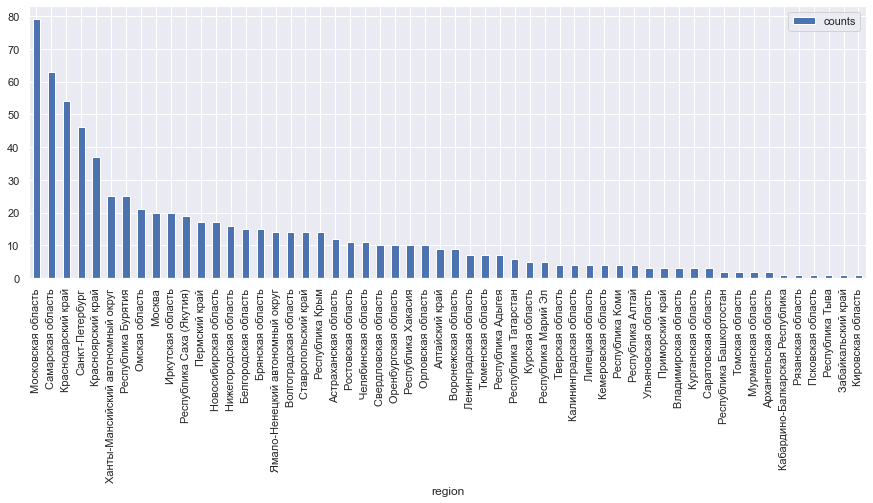

In [4]:
sns.set(rc={'figure.figsize':(15, 5)})
region = data_cola.groupby(by='region').size().reset_index(name='counts')
region.sort_values('counts', key=lambda x: -x).plot.bar(x='region', y='counts');

print(f'0.05 quantile is {region.counts.quantile(0.05)} - We have regions with very little data.', end='\n\n')
print('Distribution of the amount of data in regions')
print(region.describe(), end='\n\n')
print(f"Initial number of regions {data.region.dropna().describe()['unique']}, number of regions for the most popular can of cola {region.shape[0]}")

## quantity
quantity in initial date is a dirty field - there are negative values, very large values and float values. We will use 0.99 quantile as a highest value and 1 as a lowest.

In [5]:
print('initial quantity data:')
print(data.quantity.describe())
print('|' + '-'*40 + '|')
print('only cola quantity data:')
print(data_cola.quantity.describe())
print('|' + '-'*40 + '|')
q99 = data_cola.loc[:, ['quantity']].quantile(q=0.99).values[0]
print(f"0.99 quantile is {q99}")

initial quantity data:
count    2.246094e+06
mean     2.168133e+00
std      1.383289e+02
min     -9.350000e+03
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.500000e+04
Name: quantity, dtype: float64
|----------------------------------------|
only cola quantity data:
count    727.000000
mean       1.170564
std        0.823928
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       12.000000
Name: quantity, dtype: float64
|----------------------------------------|
0.99 quantile is 4.740000000000009


We have 98.90% of our previous data.


<AxesSubplot:>

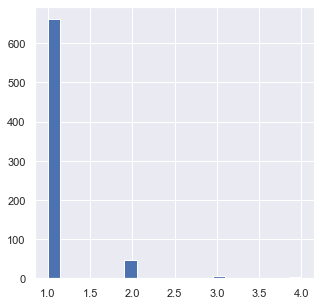

In [6]:
cleaned_data = data_cola.loc[data_cola.quantity.apply(lambda x: 1<=x<=q99) & data_cola.quantity.apply(lambda x: round(x, 0) == x)].copy()
print('We have {:6.2%} of our previous data.'.format(cleaned_data.shape[0]/data_cola.shape[0]))
sns.set(rc={'figure.figsize':(5, 5)})
cleaned_data.loc[:,'quantity'].hist(bins=20)

## local date

In [7]:
print(cleaned_data.local_date.describe(datetime_is_numeric=True))
cleaned_data.loc[:, ['region', 'local_date']].groupby(by='region').max().describe(datetime_is_numeric=True)

count                              719
mean     2021-02-04 05:33:47.961057024
min                2021-01-10 18:19:10
25%         2021-02-02 17:15:35.500000
50%                2021-02-04 12:04:32
75%                2021-02-05 19:44:36
max                2021-02-07 00:15:20
Name: local_date, dtype: object


,local_date
count,56
mean,2021-02-05 20:45:07.946428672
min,2021-01-10 18:19:10
25%,2021-02-06 04:55:43.750000128
50%,2021-02-06 17:14:29.500000
75%,2021-02-06 19:57:06.249999872
max,2021-02-07 00:15:20


We will predict our value from 2021-01-10 - 2021-02-06 and all data is about 2021 year </br>

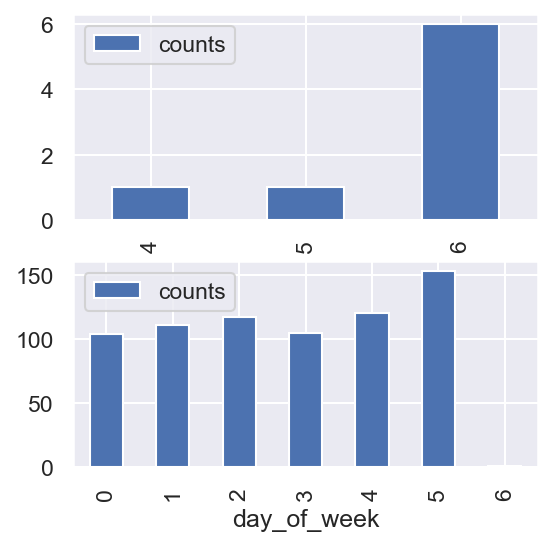

In [8]:
fig, axs = plt.subplots(2, 1, dpi=150, figsize=(4, 4))

mask = (cleaned_data['year'] == 2021) & (cleaned_data.month == 1)
cleaned_data.loc[mask].groupby(['day_of_week']).size().reset_index(name='counts').plot.bar(x='day_of_week', y='counts', ax=axs[0])

mask = (cleaned_data['year'] == 2021) & (cleaned_data.month == 2)
cleaned_data.loc[mask].groupby(['day_of_week']).size().reset_index(name='counts').plot.bar(x='day_of_week', y='counts', ax=axs[1])
axs[0].set_xlabel('');

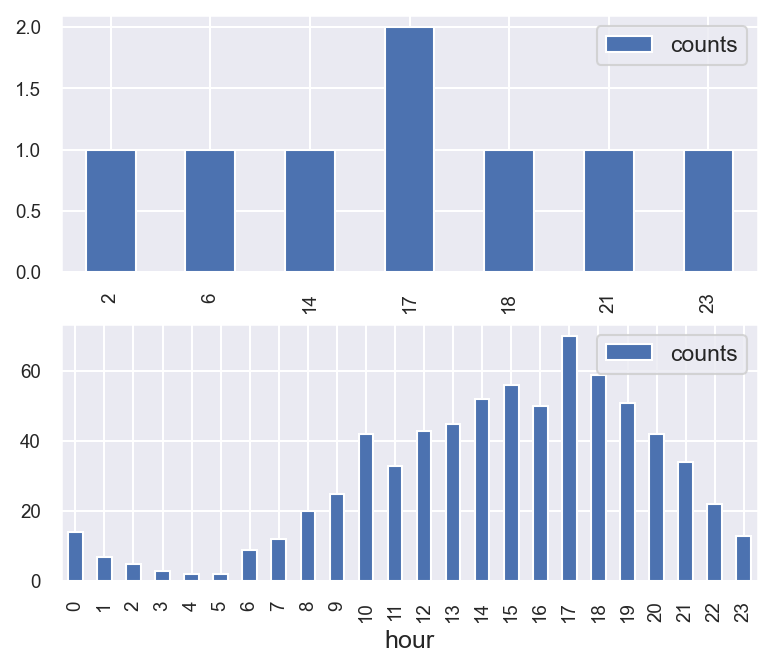

In [9]:
fig, axs = plt.subplots(2, 1, dpi=150, figsize=(6, 5))

mask = (cleaned_data['year'] == 2021) & (cleaned_data.month == 1)
cleaned_data.loc[mask].groupby(['hour']).size().reset_index(name='counts').plot.bar(x='hour', y='counts', ax=axs[0], fontsize=9)
axs[0].set_xlabel('')
mask = (cleaned_data['year'] == 2021) & (cleaned_data.month == 2)
cleaned_data.loc[mask].groupby(['hour']).size().reset_index(name='counts').plot.bar(x='hour', y='counts', ax=axs[1], fontsize=9);

There is very little info about 00:00 - 6:00 time - shops are closed or there are no buyers. So we will fill in as 0 if we dont have data. </br>
Info about day of week is not enough even during all regions.

In [10]:
print('We did not lose any region they are stil {}'.format(cleaned_data.groupby('region').size().shape[0]))
cleaned_data.loc[:, ['local_date_h']] = cleaned_data.local_date.round('H')
cleaned_data.to_csv('cleaned_data.csv')

We did not lose any region they are stil 56


# Predictions

## Choose models

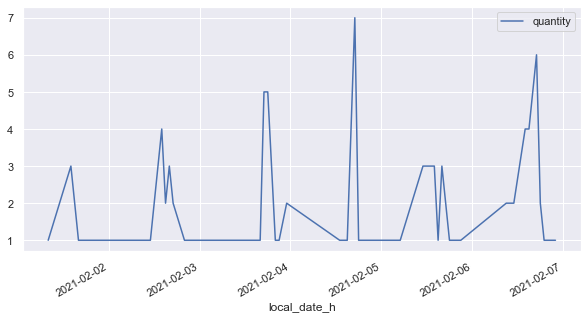

In [2]:
cleaned_data = pd.read_csv('cleaned_data.csv')
cleaned_data['local_date_h'] = pd.to_datetime(cleaned_data.local_date_h)

sns.set(rc={'figure.figsize':(10, 5)})
mask = (cleaned_data.year == 2021) &(cleaned_data.month == 2) & (cleaned_data.region == 'Московская область')
time_start = cleaned_data.loc[mask, :].local_date_h.min()
msk = cleaned_data[mask]
mask = msk.local_date_h >= time_start
msk = msk.loc[mask, ['local_date_h', 'quantity']]
msk = msk.groupby('local_date_h').sum()
msk.plot();

We can see seasonal dependings from a day. So seasonal decomposition should works. Also we will use ARIMA model and mean_value for each hour. </br>
Unfortunately, we do not have enough data for more complex methods.

### Numbers of hours in different region

Can we use these methods for all region? </br>
We can't predict anything by 1-4 values. Only by maen value.

In [3]:
regions_datetime = cleaned_data.loc[:, ['region', 'local_date_h']].groupby(by='region')
regions_time_gap = regions_datetime.max() - regions_datetime.min()
low_data = regions_time_gap[regions_time_gap.local_date_h <= pd.offsets.Hour(1)]
low_data = list(low_data.index) + list(regions_datetime.size()[regions_datetime.size()<5].index)
len(low_data)

28

There are a few values in the first month, we can delete it because it can spoil our prediction by adding fake trend.

In [4]:
regions_all_methods = list(set(regions_datetime.size().index) - set(low_data))

start_datetime = regions_datetime.min().loc[regions_all_methods, :]
values_in_first_month = start_datetime[start_datetime.local_date_h < '2021-02-01 00:00:00']
values_in_first_month

,local_date_h
region,
Самарская область,2021-01-23 18:00:00
Красноярский край,2021-01-29 18:00:00
Воронежская область,2021-01-31 22:00:00
Орловская область,2021-01-31 03:00:00


Train set for seasonal decompose has to contains at least 48 hours. </br>
Can we split it into train/test dataset for seasonal decomposition with 1 day for test dataset?

In [5]:
train_set = cleaned_data.loc[cleaned_data.region.apply(lambda x: x in regions_all_methods) & (cleaned_data.local_date_h >= '2021-02-01 00:00:00'), ['region', 'local_date_h']]
max_time = train_set.groupby('region').max()
train_set_region = train_set[train_set.local_date_h.values < (max_time.loc[train_set.region, :].local_date_h - pd.offsets.Day(1)).values].groupby('region')
if (pd.offsets.Day(2)<=(train_set_region.max() - train_set_region.min()).min()).values[0]:
    print('Yes, all other regions can be splitted into train/test set.')
else:
    print('We can not split some regions into trein/test set.')

Yes, all other regions can be splitted into train/test set.


### Choose the best
I use rmse to evaluate the best algorithm. Because I don't know the business task. And it is the most popular method for regression with mae, but because we got rid of outliers when cleaning the data, I prefer rmse.

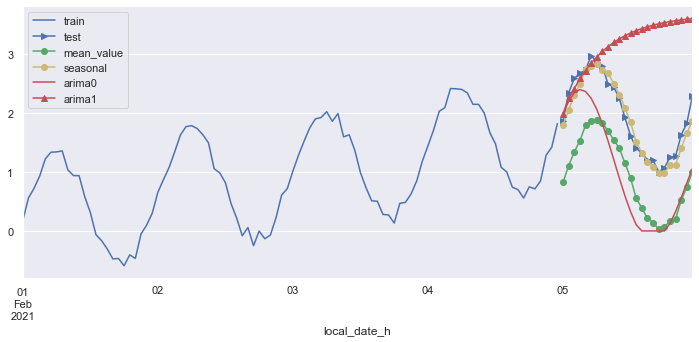

In [6]:
def train_test_split(data, n_hours=24):
    data = data.sort_index()
    
    n = int((data.index.max() - data.index.min())/pd.offsets.Hour(1)) + 1 
    data = data.reindex([data.index.min() + pd.offsets.Hour(i) for i in range(n)]).fillna(0) # fill na 0 because shops are closed or there are not buyers
    train = data[data.index <= (data.index[-1] - pd.offsets.Hour(n_hours))].copy() # choose all but the last 24 hours
    test = data[data.index > (data.index[-1] - pd.offsets.Hour(n_hours))].copy() # choose the last 24 hours
    return train, test

def rmse_all_methods(data, region='Московская область', metric=mean_squared_error):
    mask = (data.region == region) & (data.month == 2)
    data_region = data.loc[mask, ['local_date_h', 'quantity']].copy()
    if region == 'all regions':
        data_region = data.loc[:, ['local_date_h', 'quantity']].copy()
        
    data_region = data_region.groupby('local_date_h').sum()
    train, test = train_test_split(data_region)
    
    methods_rmse = []
    predictions = mean_value(train, test)
    methods_rmse.append(metric(test.quantity, predictions, squared=False))
    
    predictions = seasonal(train, test)
    methods_rmse.append(metric(test.quantity, predictions, squared=False))

    predictions = arima(train, test)
    methods_rmse.append(metric(test.quantity, predictions, squared=False))
    
    predictions = arima(train, test, 1)
    methods_rmse.append(metric(test.quantity, predictions, squared=False))
    
    return methods_rmse

def mean_value(train, test):
    test = test.reset_index()
    test['hour'] = test.loc[:, 'local_date_h'].apply(lambda x: x.hour)
    train = train.reset_index()
    train['hour'] = train.loc[:, 'local_date_h'].apply(lambda x: x.hour)
    predict = train.loc[:, ['quantity', 'hour']].groupby('hour').mean().loc[test.hour, 'quantity'].values
    return predict

def seasonal(train, test):
    decomposiotion = seasonal_decompose(train, model='additive')
    trend = decomposiotion.trend
    seasonal = decomposiotion.seasonal
    residual = decomposiotion.resid

    trend = trend.dropna()
    trend = pd.DataFrame(trend)
    trend['time_index'] = list(range(trend.shape[0]))
    
    model = RidgeCV().fit(trend[['time_index']], trend.trend)
    n = int((train.index[-1] - trend.index[-1])/pd.offsets.Hour(1)) + 2
    trend_predict = model.predict(np.array([trend.time_index[-1]+(i - trend.index[-1])/pd.offsets.Hour(1) for i in test.index])[:, np.newaxis])
    h = train.index.hour[-1] + 1 if train.index.hour[-1] < 23 else 0
    prediction = np.array([seasonal[seasonal.index.hour == i][0] for i in test.index.hour]) + trend_predict
    # some values can be negative, it is unreal, so we put them to 0
    prediction = prediction * (prediction > 0)
    
    return prediction
    
def arima(train, test, d=0):
    stepwise_fit = auto_arima(train.quantity, suppress_warnings=True, d=d, error_action="ignore")
    stepwise_fit.fit(train.quantity)
    
    n = int((test.index[-1]-train.index[-1])/pd.offsets.Hour(1))
    predicted = stepwise_fit.predict(n_periods=n)
    
    # some values can be negative, it is unreal, so we put them to 0
    predicted = predicted * (predicted > 0)    
    return predicted[np.array([(test.index[i]-train.index[-1])/pd.offsets.Hour(1) - 1 for i in range(test.shape[0])], dtype='int32')]


# Let's do a simple test with daily seasonality and trend.

def simple_test(n=120):
    index = [pd.to_datetime('2021-02-01 00:00:00') + pd.offsets.Hour(i) for i in range(n)]
    data = {'q': np.sin(np.linspace(0, 2*np.pi*n/24, n)) + np.linspace(0, 2, n) + np.random.rand(n)*0.3, 'date': pd.DataFrame(index)[0]}
    df = pd.DataFrame({'quantity': data['q']}, index = data['date'])
    df.index.name = 'local_date_h'
    train, test = train_test_split(df)
    fig, ax = plt.subplots(figsize=(12, 5))
    train.plot(ax=ax, legend=False, style='-b')
    test.plot(ax=ax, legend=False, style='->b')

    test['quantity'] = mean_value(train, test)
    test.plot(ax=ax, legend=False, style='-og')

    test['quantity'] = seasonal(train, test)
    test.plot(ax=ax, legend=False, style='-oy')

    test['quantity'] = arima(train, test, 0)
    test.plot(ax=ax, legend=False, style='-r')

    test['quantity'] = arima(train, test, 1)
    test.plot(ax=ax, legend=False, style='-^r');

    ax.legend(['train', 'test', 'mean_value', 'seasonal', 'arima0', 'arima1'])
simple_test()

As we can see - seasonal decomposition works better then other methods.

In [7]:
models_rmse = []
for region in tqdm(regions_all_methods):
    try:
        models_rmse.append(rmse_all_methods(cleaned_data, region))
    except Exception as e:
        print(region)

  0%|          | 0/34 [00:00<?, ?it/s]

In [8]:
rmse_methods = pd.DataFrame(models_rmse, columns=['mean_value', 'seasonal', 'arima0', 'arima1'], index=regions_all_methods)
counter_methods = Counter(rmse_methods.idxmin(axis=1))
print(counter_methods)
rmse_methods.head(5)

Counter({'arima0': 15, 'mean_value': 8, 'seasonal': 6, 'arima1': 5})


,mean_value,seasonal,arima0,arima1
Самарская область,0.979211,1.041079,0.912213,1.258542
Республика Крым,0.647511,0.749784,0.697575,0.765848
Красноярский край,0.716764,0.757025,0.711914,0.688133
Омская область,1.591718,1.621253,1.753937,1.703256
Тюменская область,0.354436,0.352433,0.338778,0.498425


In [9]:
seasonal_data_size = regions_datetime.size()[rmse_methods.idxmin(axis=1)[rmse_methods.idxmin(axis=1) == 'seasonal'].index].mean()
arima1_data_size = regions_datetime.size()[rmse_methods.idxmin(axis=1)[rmse_methods.idxmin(axis=1) == 'arima1'].index].mean()
print('Arima1 shows better result for lower dataset seasonal mean dataset size: {}, arima dataset mean size: {}'.format(seasonal_data_size, arima1_data_size))
print('RMSE for all data mean_value = {:.3f}, seasonal = {:.3f}, arima0 = {:.3f}, arima1 = {:.3f}'.format(*rmse_all_methods(cleaned_data, 'all regions')))

Arima1 shows better result for lower dataset seasonal mean dataset size: 31.5, arima dataset mean size: 22.8
RMSE for all data mean_value = 8.074, seasonal = 6.589, arima0 = 7.796, arima1 = 6.265


In most cases arima0 is the best method. Arima1 and seasonal in case of a general dataset </br>

## Predict
In the terms of reference, it was said to predict the next day or 24 hours. Therefore, I will predict both for the rest of the last day and for the next day.

In [10]:
def prepare_data(data, region='Московская область'):
    mask = (data.region == region)  & (data.month == 2)
    data_region = data.loc[mask, ['local_date_h', 'quantity']].copy()
    data_region = data_region.groupby('local_date_h').sum()
    data_region = data_region.sort_index()
    n = int((data_region.index.max() - data_region.index.min())/pd.offsets.Hour(1)) + 1 # fill the gaps
    n = 24 if n<24 else n
    data_region = data_region.reindex([data_region.index.min() + pd.offsets.Hour(i) for i in range(n)]).fillna(0)
    return data_region

def predict(data_region, method='seasonal'):
    n = 24 if data_region.index[-1].hour == 0 else 48 - data_region.index[-1].hour
    index = [data_region.index[-1] + pd.offsets.Hour(i) for i in range(1, n+1)]
    data = {'q': np.zeros(n), 'date': pd.DataFrame(index)[0]}
    df = pd.DataFrame({'quantity': data['q']}, index = data['date'])
    df.index.name = 'date'
    if method == 'seasonal':
        prediction = seasonal(data_region, df)
        df['quantity'] = prediction
        return df
    elif method == 'arima0':
        prediction = arima(data_region, df)
        df['quantity'] = prediction
        return df
    elif method == 'arima1':
        prediction = arima(data_region, df, 1)
        df['quantity'] = prediction[:n]
        return df
    elif method == 'mean_value':
        df.index.name = 'local_date_h'
        prediction = mean_value(data_region, df)
        df['quantity'] = prediction[:n]
        return df

  0%|          | 0/15 [00:00<?, ?it/s]

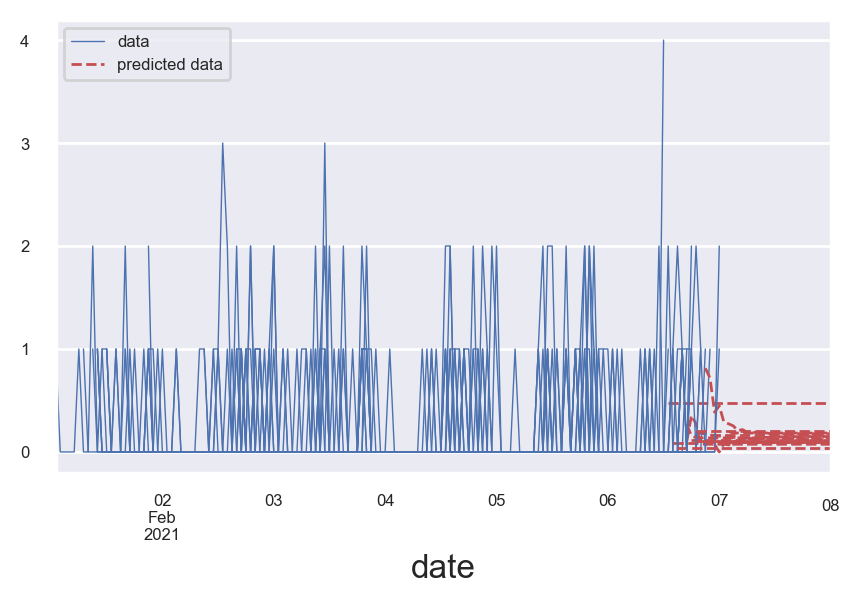

In [11]:
def draw_one(regions, method):
    fig, ax = plt.subplots(1, figsize=(5, 3), dpi=200)
    with tqdm(total=len(regions), file=sys.stdout, leave=False) as prbar:
        for cnt, i in enumerate(regions):
            data = prepare_data(cleaned_data, i)
            data.plot(ax=ax, legend=False, color=['b'], linewidth=0.5)
            predict(data, method).plot(ax=ax, legend=False, fontsize=6, style=['--'], color=['r'], linewidth=1)
            ax.legend(['data', 'predicted data'], fontsize=6)
            prbar.update(1)
draw_one(rmse_methods[rmse_methods.idxmin(axis=1) == 'arima0'].index, 'arima0')

  0%|          | 0/5 [00:00<?, ?it/s]

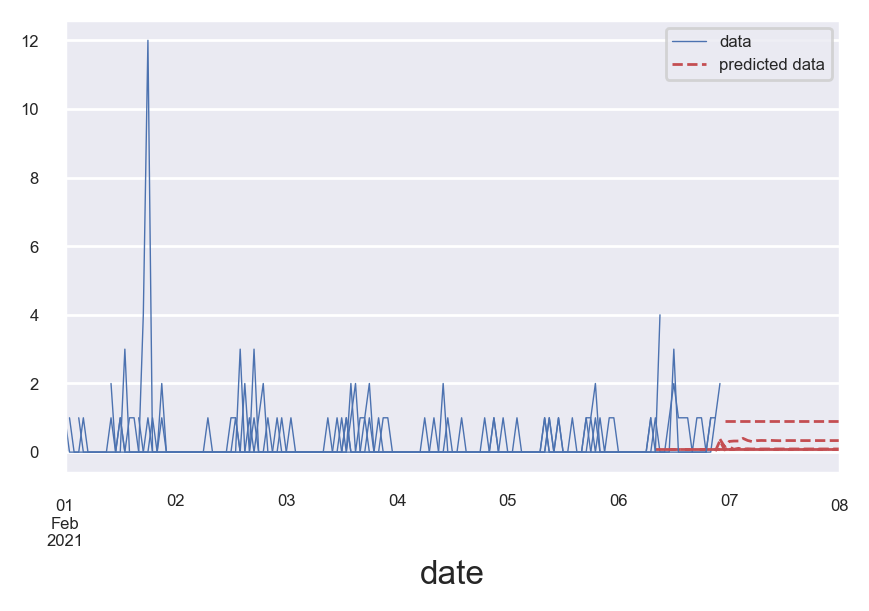

In [12]:
draw_one(rmse_methods[rmse_methods.idxmin(axis=1) == 'arima1'].index, 'arima1')

  0%|          | 0/8 [00:00<?, ?it/s]

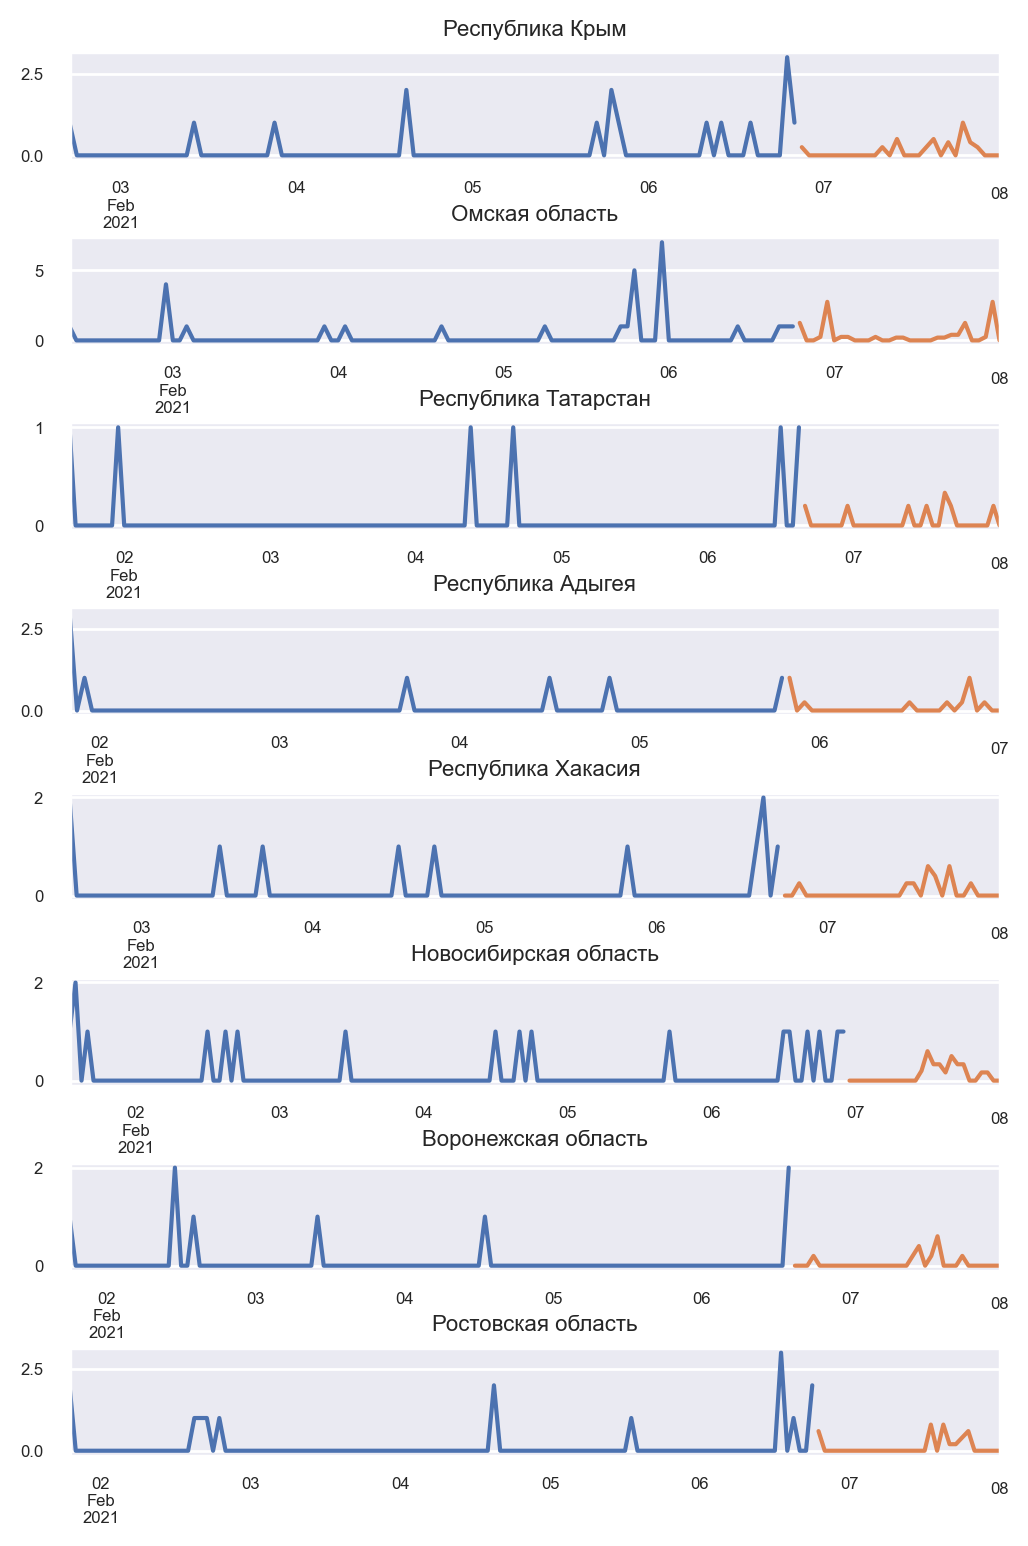

In [13]:
def draw_mult(regions, method):
    fig, ax = plt.subplots(len(regions), figsize=(6, 1.2*len(regions)), dpi=200)
    with tqdm(total=len(regions), file=sys.stdout, leave=False) as prbar:
        for cnt, i in enumerate(regions):
            data = prepare_data(cleaned_data, i)
            data.plot(ax=ax[cnt], legend=False)
            prediction = predict(data, method)
            prediction.plot(ax=ax[cnt], legend=False, fontsize=6)
            box = ax[cnt].get_position()
            ax[cnt].set_position([box.x0, box.y0, box.width, box.height*0.7])
            ax[cnt].set_xlabel('')
            ax[cnt].set_title(i, fontsize=8)
            prbar.update(1)
draw_mult(rmse_methods[rmse_methods.idxmin(axis=1) == 'mean_value'].index, 'mean_value')

  0%|          | 0/6 [00:00<?, ?it/s]

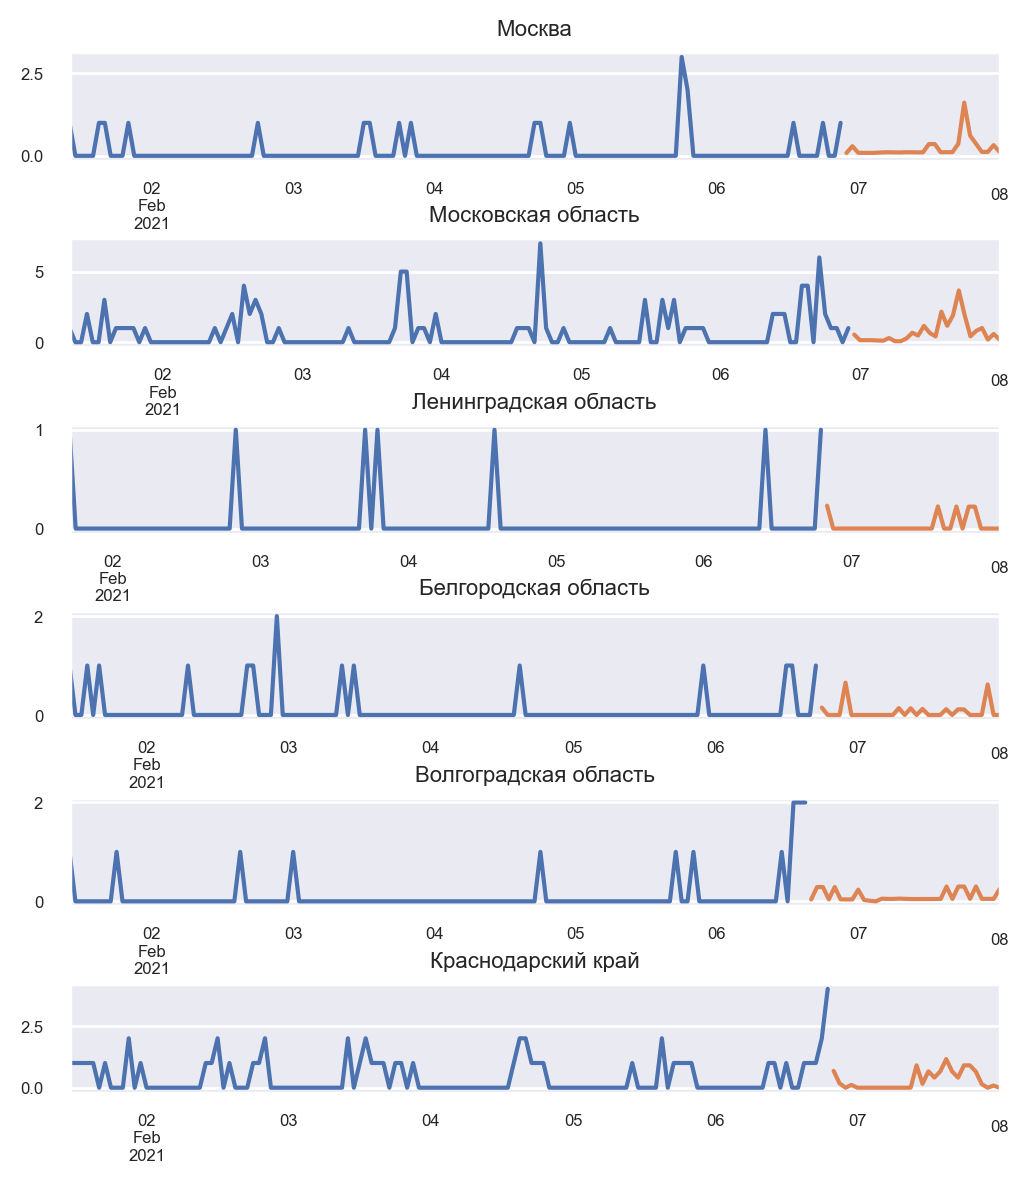

In [14]:
draw_mult(rmse_methods[rmse_methods.idxmin(axis=1) == 'seasonal'].index, 'seasonal')

## Analysis of results
Arima model showed the best rmse value but it does not seem reasonable. We can see seasonal depending in each case, but arima in most cases goes to a platoo very soon. Also, our data is very little. </br>
Mean Value and seasonal depending look much more reasonable. So maybe it is better to predict based on these methods. Some test sets contain 2-3 values. And better arima values can be the result of it.

### Test on whole dataset
Let's try our methods on the whole dataset not only for coca-cola but for all. We will do a rough data processing and simply do not include in the statistics the regions where our algorithm breaks down.

In [15]:
data = pd.read_csv('dataset.csv').drop(columns=['item_id', 'receipt_id', 'device_id', 'Unnamed: 0', 'price'])
data['local_date'] = pd.to_datetime(data.local_date)
data = data.loc[data.quantity.apply(lambda x: 1<=x<=10) & data.quantity.apply(lambda x: round(x, 0) == x)].copy()
data.loc[:, ['local_date_h']] = data.local_date.round('H')
data = data[data.local_date_h >= '2021-02-01 00:00:00']
data['month'] = data.loc[:, "local_date"].apply(lambda x: x.month)

In [16]:
rmse_all_goods = []
regions = list(set(data.region.dropna().values))
idx = []
for i in tqdm(regions):
    try:
        rmse_all_goods.append(rmse_all_methods(data, i))
        idx.append(i)
    except Exception as e:
        pass

rmse_all_goods = pd.DataFrame(rmse_all_goods, columns=['mean_value', 'seasonal', 'arima0', 'arima1'], index=idx)
Counter(rmse_all_goods.idxmin(axis=1))

  0%|          | 0/85 [00:00<?, ?it/s]

Counter({'mean_value': 42, 'seasonal': 34, 'arima0': 5, 'arima1': 2})

As we can see, seasonal and mean value works much better. </br>
Maybe cola is not the seasonal product? Let's choose regions with enough data and all cans of cola.

In [17]:
data['barcode'] = data['barcode'].astype(str)
data_cola = data[data.barcode.apply(lambda x: '5449' == ''.join(re.findall('\d+', x))[:4])].copy()

data_cola_counts = data_cola.loc[:, ['region', 'quantity']].groupby('region')#.size().describe()
data_cola_counts.size().describe()

count     71.000000
mean      66.535211
std      104.785063
min        1.000000
25%       11.000000
50%       24.000000
75%       65.000000
max      526.000000
dtype: float64

In [18]:
regions = data_cola_counts.size()[data_cola_counts.size() >= data_cola_counts.size().describe()['75%']].index
idx = []
rmse_all_cola = []
for i in tqdm(regions):
    try:
        rmse_all_cola.append(rmse_all_methods(data_cola, i))
        idx.append(i)
    except Exception as e:
        pass

rmse_all_cola = pd.DataFrame(rmse_all_cola, columns=['mean_value', 'seasonal', 'arima0', 'arima1'], index=idx)
Counter(rmse_all_cola.idxmin(axis=1))

  0%|          | 0/19 [00:00<?, ?it/s]

Counter({'seasonal': 5, 'mean_value': 10, 'arima0': 4})

Now arima shows better results. However, we greatly reduced our sample. Anyway, seasonal and mean_value show better results than arima. </br>
Let's have a look at rmse for the whole day.

In [19]:
def rmse_by_day(test, predict, *args, **kwargs):
    return ((np.sum(test.values) - np.sum(predict))**2)**0.5
    
models_rmse = []
for region in tqdm(regions_all_methods):
    try:
        models_rmse.append(rmse_all_methods(cleaned_data, region, rmse_by_day))
    except Exception as e:
        print(region)

  0%|          | 0/34 [00:00<?, ?it/s]

In [20]:
rmse_methods = pd.DataFrame(models_rmse, columns=['mean_value', 'seasonal', 'arima0', 'arima1'], index=regions_all_methods)
counter_methods = Counter(rmse_methods.idxmin(axis=1))
print(counter_methods)
rmse_methods.head(5)

Counter({'arima0': 15, 'seasonal': 7, 'arima1': 6, 'mean_value': 6})


,mean_value,seasonal,arima0,arima1
Самарская область,0.750000,0.622616,0.555555,20.616359
Республика Крым,4.416667,4.901674,4.157895,8.650841
Красноярский край,7.700000,8.784512,7.275229,1.801166
Омская область,12.333333,13.762373,12.487805,2.687441
Тюменская область,1.800000,2.115644,1.762887,7.106523


It seems as if arima shows better results as a mean value by a day. But, our task is not to predict quantity for the day, but for each hour.

#### Сonclusions
I think it's worth making a prediction for all regions, also based on the average and seasonality. When increasing the dataset, these methods will perform better than arima. They are also more resistant to long-term predictions than Arima.

  0%|          | 0/10 [00:00<?, ?it/s]

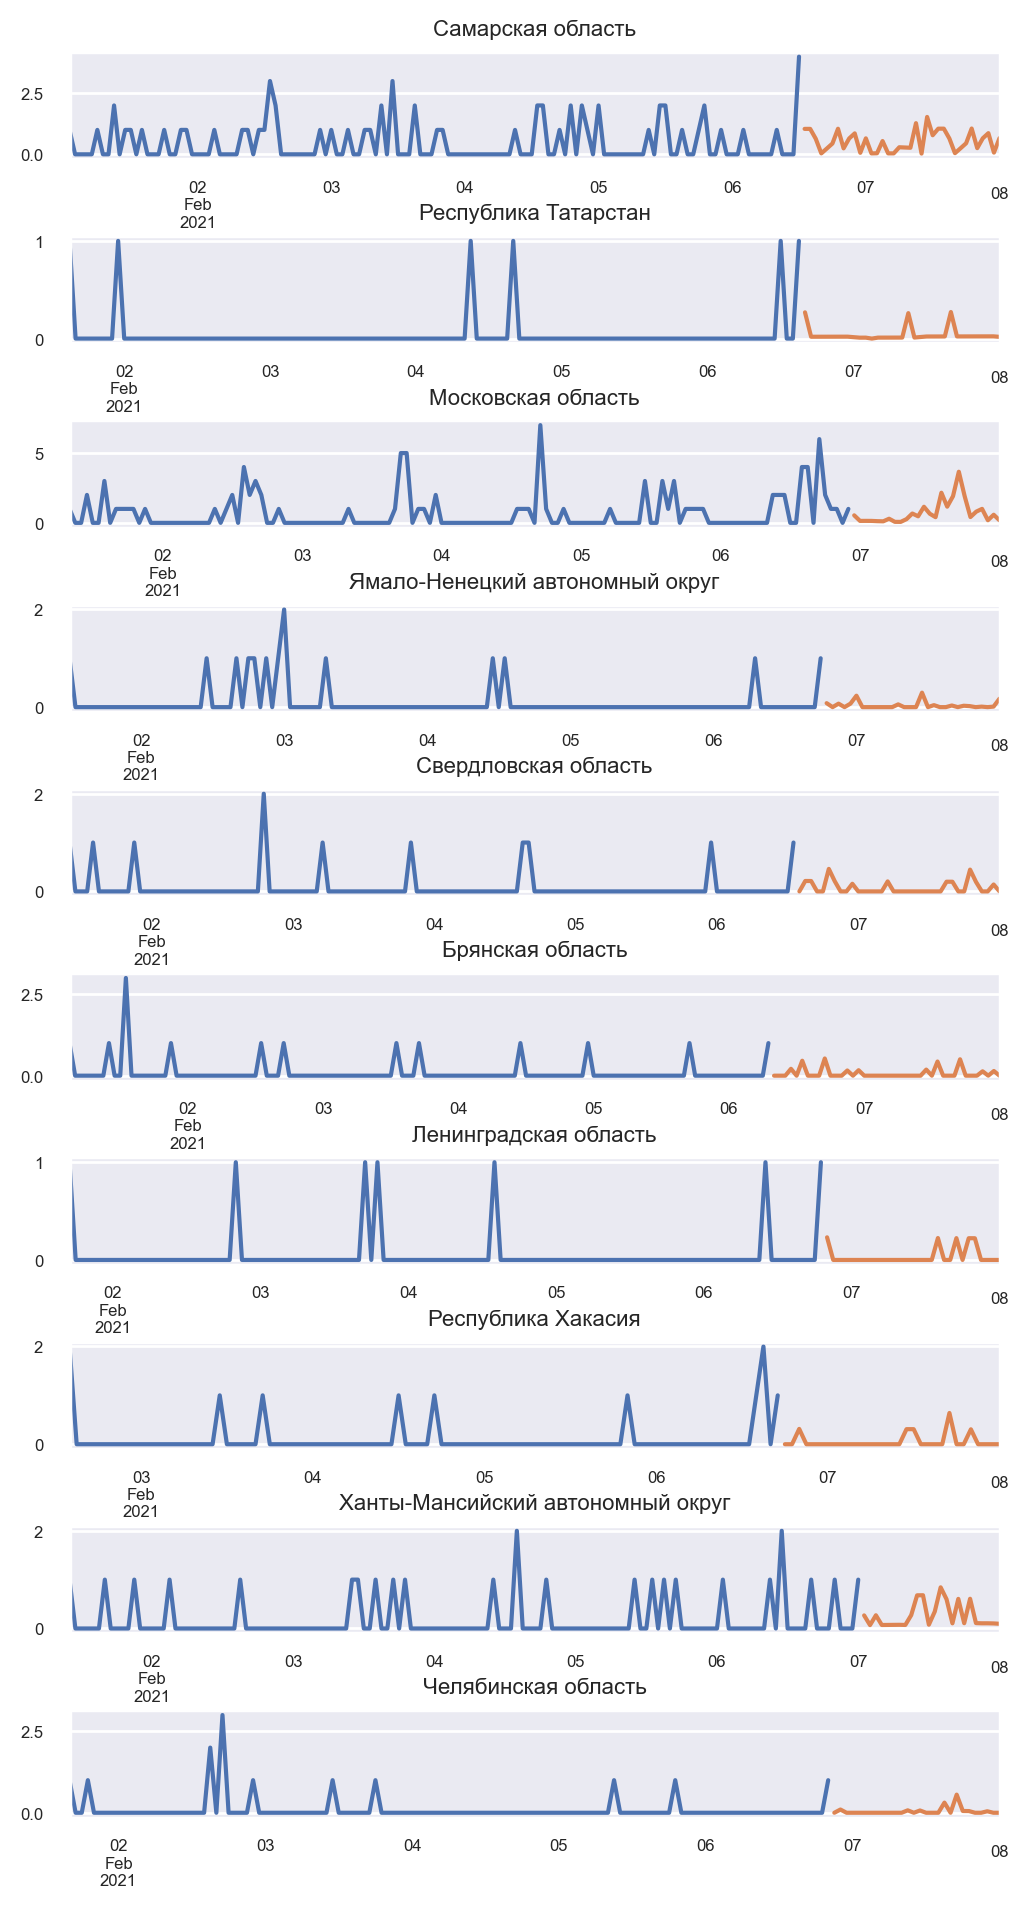

In [21]:
draw_mult(rmse_methods[rmse_methods.seasonal < rmse_methods.mean_value].index, 'seasonal')

  0%|          | 0/24 [00:00<?, ?it/s]

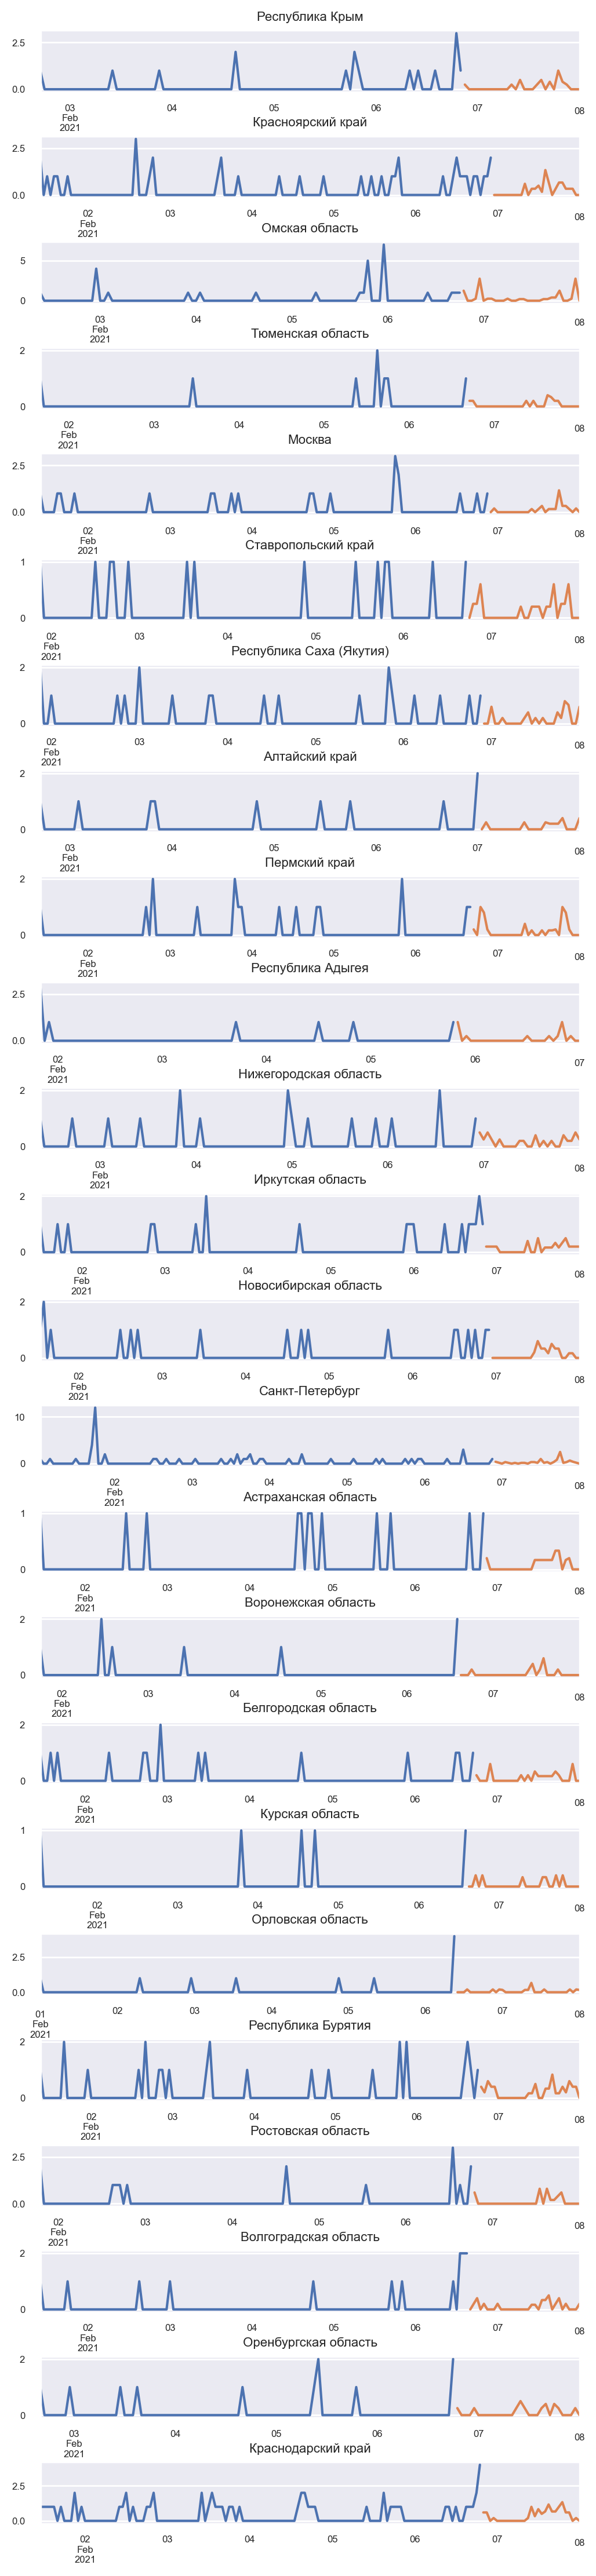

In [22]:
draw_mult(rmse_methods[rmse_methods.seasonal > rmse_methods.mean_value].index, 'mean_value')

## Predict low_freq data

Out of 85 regions, such a can of cola is sold in 56. In the remaining 29 regions, there will also be 0 purchases. </br>
For regions where there were 2-4 purchases, we cannot adequately predict further purchases. Is it just the average. </br>
For regions with one purchase - the only prediction is another purchase at the same hour of the next day.

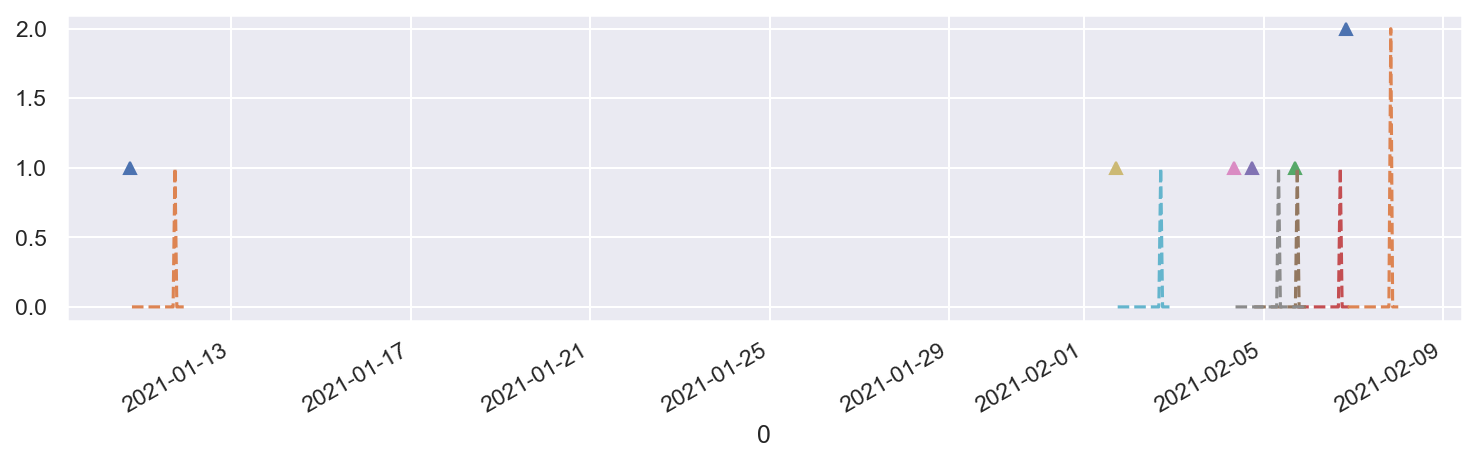

In [23]:
one_can = regions_datetime.size()[regions_datetime.size()==1].index

def predict_one(data_region):
    n = 24 if data_region.index[-1].hour == 0 else 48 - data_region.index[-1].hour
    index = [data_region.index[-1] + pd.offsets.Hour(i) for i in range(1, n+1)]
    
    data = {'q': np.zeros(n), 'date': pd.DataFrame(index)[0]}
    df = pd.DataFrame({'quantity': data['q']}, index = data['date'])
    df[df.index.hour == data_region.index.hour.values[0]] = data_region.iloc[0]
    
    return df

fig, ax = plt.subplots(figsize=(12, 3), dpi=150)
for i in one_can:
    data_region = cleaned_data.loc[cleaned_data.region == i, ['local_date_h', 'quantity']].groupby('local_date_h').sum()
    data_region.plot(ax=ax, style='^', legend=False)
    predict_one(data_region).plot(ax=ax, style='--', legend=False)

  0%|          | 0/16 [00:00<?, ?it/s]

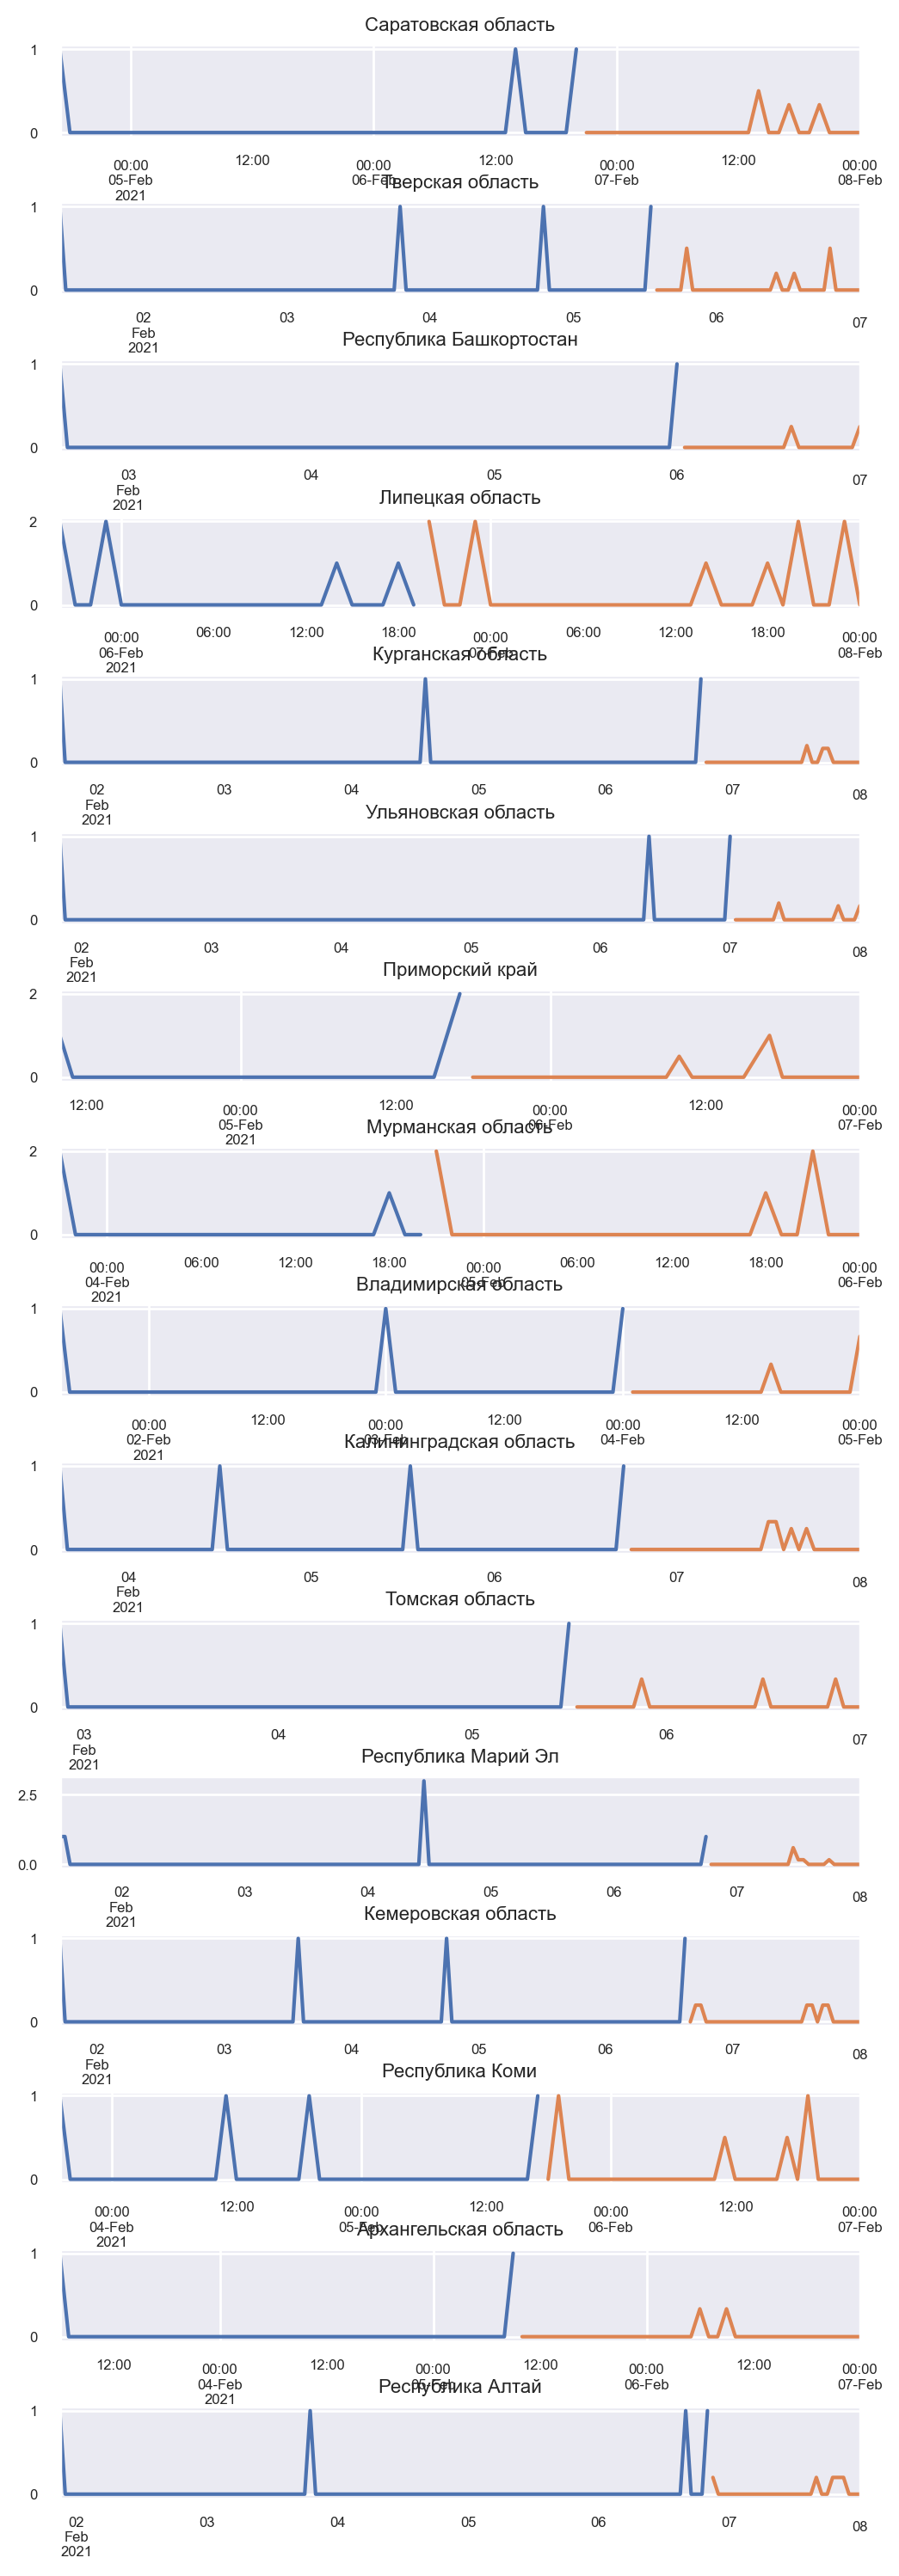

In [24]:
few_cans = list(set(low_data) - set(one_can))
draw_mult(few_cans, 'mean_value')